# Optimize Free parameters $\alpha$ and $r_{h}$ in the HUX model

### Optimization method: Nonlinear least squares fit. 

### Non-linear least squares minimizes the sum of squares difference between the data and the model. 


$$S = \sum_{i=1}^{m} {r_{i}}^2$$

$$r_{i} = y_{i} - f(x_{i}, \alpha, r_{h})$$


In [2]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from scipy import stats
import scipy.optimize as optimization
import scipy

%matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 5] # default fig size.

# HUX-f Pseudocode 

![](figures/HUX_F_pc.png)

# Apply the HUX-f mapping

In [3]:
def hux_f_mapping(r_initial, r, p, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True):
    """ apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    v_next = np.zeros(len(p)) # initialize v_next, r = 1
    v_prev = r_initial # v_previous, r = 0

    if add_v_acc:
        v_acc = alpha * (v_prev*(1 - np.exp(-r[0]/rh)))
        v_prev = v_acc + v_prev

    for i in range(len(r) -1):
        for j in range(len(p)):

            if j == len(p) -1: # force periodicity 
                v_next[-1] = v_next[0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v_prev[j]) > 1:
                    break

                frac1 = (v_prev[j+1] - v_prev[j]) / v_prev[j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v_next[j] = v_prev[j] + frac1*frac2
                
        if i != len(r) -2:
            v_prev = v_next 

    return v_next

In [4]:
def get_hux_approx_at_1_au(r_initial, r, p, t, omega_rot, dr_vec, dp_vec, alpha, rh):
    """ return the solar wind proton velocity at r = 1 AU for all slices in theta. """
    upwind_approx = np.ones((len(p), len(t)))
    for ii in range(len(t)):
        upwind_approx[:, ii] = hux_f_mapping(r_initial[:, ii], r, p, omega_rot, dr_vec, dp_vec, alpha, rh)
    return np.matrix.flatten(upwind_approx)

In [5]:
# read the 3d hdf file. 
hdf_file_path = "data/vr002.hdf"
r, t, p, f = rdhdf_3d(hdf_file_path)

In [6]:
# change scalers units: 
# Theta: from radians to degrees. colatitude. 
t[0] = 0
t[-1] = np.pi
t_plot = np.pi/2 - t
t_plot = np.sin(t_plot)

In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

In [8]:
# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

In [9]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r = (695700)*r

In [10]:
# Velocity profile: PSI convertion units conversion from MAS to cgs. 
# See: https://www.researchgate.net/figure/Converting-from-MAS-code-units-to-cgs-and-MKS_tbl1_228551881
f = (481.3711)*f

In [11]:
# slice velocity_mat, for r first index (30 solar radii).
v_initial = f[:, :, 0]
print("shape of v_iniital", np.shape(f))
# slice velocity_mat, for r last index(approx 1 AU).
v_final = f[:, :, -1]
print("shape of v_final", np.shape(f))

shape of v_iniital (129, 111, 140)
shape of v_final (129, 111, 140)


In [12]:
# setting parameters. 
omega_rot = (2*np.pi)/(25.38*86400)
alpha = 0.15
rh = 50* (695700)
# setting parameters. The phi and radial mesh spacing. 
dp_vec = p[1:] - p[:-1]
dr_vec = r[1:] - r[:-1]

In [13]:
# create the model function with free - parameters: [alpha, rh]. 
fit_model_1 = lambda r_initial, alpha, rh: get_hux_approx_at_1_au(r_initial, r, p, t, omega_rot, dr_vec, dp_vec, alpha, rh)

In [14]:
popt, _ = scipy.optimize.curve_fit(f=fit_model_1, xdata=v_initial, ydata=np.matrix.flatten(v_final), p0=[0.15, 50*(695700)])

In [15]:
print("The optimal alpha: ", popt[0])

The optimal alpha:  0.3108286418705637


In [16]:
print("The optimal rh: " + str(popt[1]/(695700)) + " (RS)")

The optimal rh: 43.7832928222575 (RS)


## Plot the relative error using the parameter values above, and compare with initial parameters. 

In [17]:
# first for alpha = 0.15 and rh = 50 solar radii. 
result_1 = get_hux_approx_at_1_au(v_initial, r, p, t, omega_rot, dr_vec, dp_vec, 0.15, 50*(695700))
# unflatten the result. 
result_1 = result_1.reshape(len(p), -1)

In [18]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p[0]], 0.5 * (p[1:] + p[:-1]), [p[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

<IPython.core.display.Javascript object>


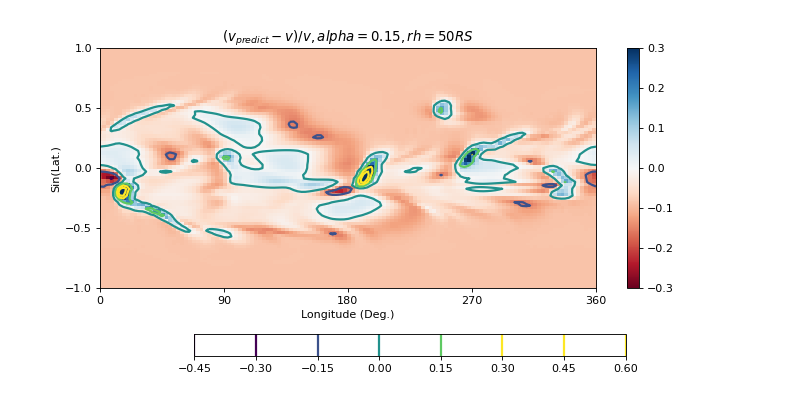

In [19]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("$ (v_{predict} - v) / v, alpha=0.15, rh=50 RS$")
ax.set_ylabel("Sin(Lat.)")
ax.set_xlabel("Longitude (Deg.)")
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im1 = ax.contour((180/np.pi)*p , t_plot, np.subtract(result_1.T, v_final.T)/v_final.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax.pcolorfast(ph*((180/np.pi)), th, np.subtract(result_1.T, v_final.T)/v_final.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
_ = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.07, anchor=(2,0.0))
_ = fig.colorbar(im2, ax=ax)

In [23]:
print("MSE = ", np.square(np.subtract(result_1, v_final)).mean())

MSE =  3435.401551949361


In [24]:
# first for alpha = 0.31 and rh = 43.78 solar radii. 
result_2 = get_hux_approx_at_1_au(v_initial, r, p, t, omega_rot, dr_vec, dp_vec, popt[0] , popt[1])
# unflatten the result. 
result_2 = result_2.reshape(len(p), -1)

<IPython.core.display.Javascript object>


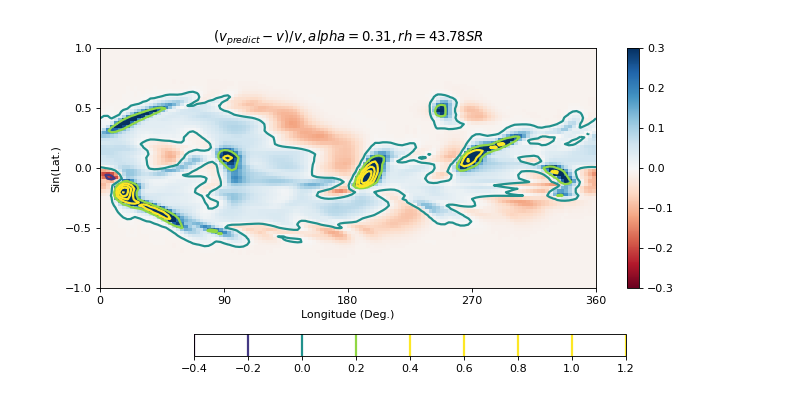

In [25]:
fig2, ax2 = plt.subplots()
ax2.set_ylim(-1, 1)
ax2.set_xlim(0, 360)
ax2.set_title("$ (v_{predict} - v) / v, alpha=0.31, rh=43.78 SR$")
ax2.set_ylabel("Sin(Lat.)")
ax2.set_xlabel("Longitude (Deg.)")
ax2.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax2.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im1 = ax2.contour((180/np.pi)*p , t_plot, np.subtract(result_2.T, v_final.T)/v_final.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax2.pcolorfast(ph*((180/np.pi)), th, np.subtract(result_2.T, v_final.T)/v_final.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
_ = fig.colorbar(im1, ax=ax2, orientation="horizontal", fraction=0.07, anchor=(2,0.0))
_ = fig.colorbar(im2, ax=ax2)

In [26]:
print("MSE = ", np.square(np.subtract(result_2, v_final)).mean())

MSE =  725.6918831972814


<IPython.core.display.Javascript object>


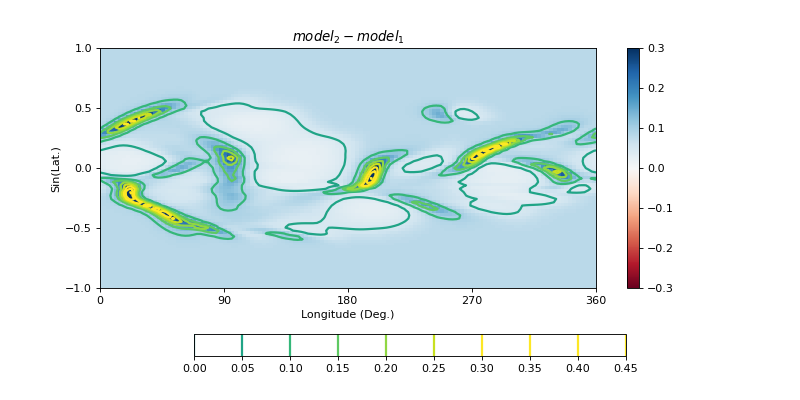

In [27]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("$ model_2 - model_1 $")
ax.set_ylabel("Sin(Lat.)")
ax.set_xlabel("Longitude (Deg.)")
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im1 = ax.contour((180/np.pi)*p , t_plot, np.subtract(result_2.T, result_1.T)/result_1.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax.pcolorfast(ph*((180/np.pi)), th, np.subtract(result_2.T, result_1.T)/result_1.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
_ = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.07, anchor=(2,0.0))
_ = fig.colorbar(im2, ax=ax)

In [28]:
print("MSE = ", np.square(np.subtract(result_2, result_1)).mean())

MSE =  2724.483798070219


# Differential Rotation. 
For more info: 
[Click here]( https://iopscience.iop.org/article/10.1086/504289/pdf)

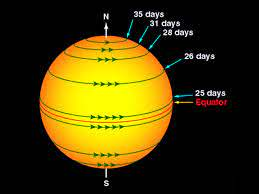

$ \omega (\theta) = - 2.°77 \cos(\theta)^2 day^{-1}$


$ \Omega_{rot} (\theta) = \frac{2\pi}{25.38} - \frac{2.77\pi}{180} cos(\theta)^2 $


In [29]:
def get_hux_approx_at_1_au_adj_omega(r_initial, r, p, t, dr_vec, dp_vec, alpha, rh, omega_rot_at_eq=25.38):
    """ return the solar wind proton velocity at r = 1 AU"""
    upwind_approx = np.ones((len(p), len(t)))
    for ii in range(len(t)):
        omega_rot = 2*np.pi/(get_omega_rot(t[ii], omega_rot_at_eq)*86400)
        upwind_approx[:, ii] = hux_f_mapping(r_initial[:, ii], r, p, omega_rot, dr_vec, dp_vec, alpha, rh)
    return np.matrix.flatten(upwind_approx)

In [30]:
# initialize the parameters 
def get_omega_rot(theta, omega_rot_at_equator=25.38):
    w_t = -2.77*np.pi/180
    res = 2*np.pi/omega_rot_at_equator + w_t*(np.cos(theta)**2)
    days = (res/(2*np.pi))**-1
    return days

In [31]:
# omega rotation at the pole. 
get_omega_rot(0)

31.539116333111725

In [32]:
# omega rotation at the equator. 
get_omega_rot(np.pi/2)

25.38

In [33]:
# omega rotation at theta=pi/4.
get_omega_rot(np.pi/4)

28.126324655139456

In [34]:
result_3 = get_hux_approx_at_1_au_adj_omega(r_initial=v_initial, r=r, p=p, t=t, dr_vec=dr_vec, dp_vec=dp_vec, alpha=0.15, rh=50*(695700),omega_rot_at_eq=25.38)
# unflatten the result. 
result_3 = result_3.reshape(len(p), -1)

<IPython.core.display.Javascript object>


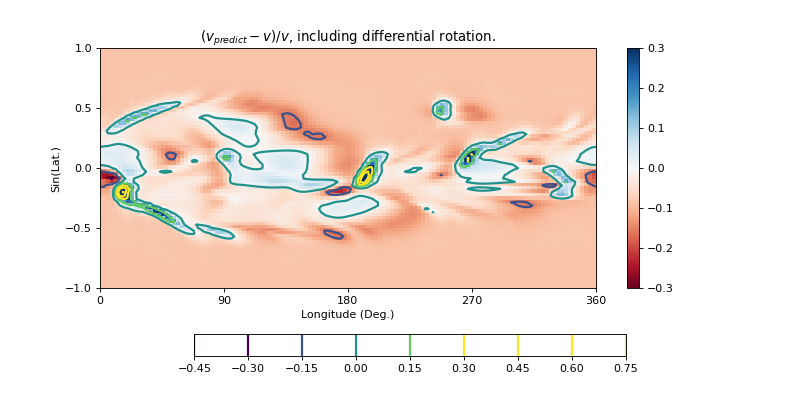

In [35]:
fig, ax = plt.subplots()
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("$ (v_{predict} - v) / v$, including differential rotation.")
ax.set_ylabel("Sin(Lat.)")
ax.set_xlabel("Longitude (Deg.)")
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im1 = ax.contour((180/np.pi)*p , t_plot, np.subtract(result_3.T, v_final.T)/v_final.T, linewidths=2, vmin=-0.3, vmax=0.3)
_ = im2 = ax.pcolorfast(ph*((180/np.pi)), th, np.subtract(result_3.T, v_final.T)/v_final.T, cmap="RdBu", vmin=-0.3, vmax=0.3)
_ = fig.colorbar(im1, ax=ax, orientation="horizontal", fraction=0.07, anchor=(2,0.0))
_ = fig.colorbar(im2, ax=ax)

In [40]:
print("MSE = ", np.square(np.subtract(result_3, v_final)).mean())
print("Improvement from static omega_rot", 3435.4004432599318- np.square(np.subtract(result_3, v_final)).mean())

MSE =  3485.439051001013
Improvement from static omega_rot -50.03860774108125


Observation: theres is not improvement when adjusting omega_rot. 

In [41]:
print("MSE at the equator result 1 = ", np.square(np.subtract(result_1[:, 55], v_final[:, 55])).mean())
print("MSE at the equator result 2 = ", np.square(np.subtract(result_2[:, 55], v_final[:, 55])).mean())
print("MSE at the equator result 3 = ", np.square(np.subtract(result_3[:, 55], v_final[:, 55])).mean())

MSE at the equator result 1 =  1141.4848743882774
MSE at the equator result 2 =  2712.028213333631
MSE at the equator result 3 =  1141.4848743882787


In [42]:
print("MSE around the equator (+-7.25 deg) result 1 = ", np.square(np.subtract(result_1[:, 50:60], v_final[:, 50:60])).mean())
print("MSE around the equator (+-7.25 deg) result 2 = ", np.square(np.subtract(result_2[:, 50:60], v_final[:, 50:60])).mean())
print("MSE around the equator (+-7.25 deg) result 3 = ", np.square(np.subtract(result_3[:, 50:60], v_final[:, 50:60])).mean())

MSE around the equator (+-7.25 deg) result 1 =  1607.0815641617198
MSE around the equator (+-7.25 deg) result 2 =  2944.4809145427043
MSE around the equator (+-7.25 deg) result 3 =  1618.4131494190233


In [43]:
print("MSE full sun result 1 = ", np.square(np.subtract(result_1, v_final)).mean())
print("MSE full sun result 2 = ", np.square(np.subtract(result_2, v_final)).mean())
print("MSE full sun result 3 = ", np.square(np.subtract(result_3, v_final)).mean())

MSE full sun result 1 =  3435.401551949361
MSE full sun result 2 =  725.6918831972814
MSE full sun result 3 =  3485.439051001013


## Note: The results above have are bias towards the poles, and therefore, it is important to optimize the free parameters at an interval closer to the equator. 

# Optimize $\alpha$ and $r_{h}$ around the equator (±7.25 deg)

In [44]:
t = t[51:60]
print("t interval = " + str(t[0]*180/np.pi) + " to " + str(t[-1]*180/np.pi) + " deg")

t interval = 83.39449240721298 to 96.60550577155418 deg


In [47]:
omega_rot_vec = np.zeros(9)
for ii in range(len(omega_rot_vec)):
    omega_rot_vec[ii] = 2*np.pi/(get_omega_rot(t[ii], 25.38)*86400)

In [48]:
# initialize matrix with free-parameters. 
optimial_free_params = np.zeros((2, len(omega_rot_vec)))

In [49]:
# create the model function with free - parameters: [alpha, rh]. 
model = lambda r_initial, alpha, rh: hux_f_mapping(r_initial, r, p, omega_rot, dr_vec, dp_vec, alpha, rh)

In [50]:
# create the model function with free - parameters: [alpha, rh]. 
for ii in range(0, len(omega_rot_vec)):
    omega_rot = omega_rot_vec[ii]
    popt, _ = scipy.optimize.curve_fit(f=model, xdata=v_initial[:,51+ii], ydata=v_final[:, 51+ii], p0=[0.15, 50*(695700)], bounds=[[0,0],[1,90*(695700)]])
    optimial_free_params[0, ii] = popt[0]
    optimial_free_params[1, ii] = popt[1]

<IPython.core.display.Javascript object>


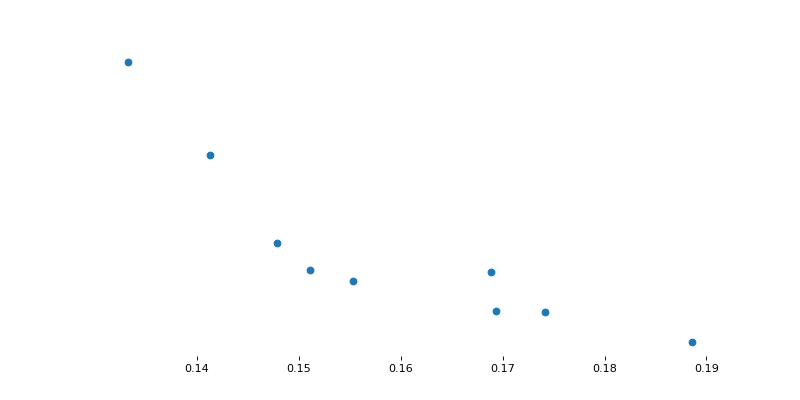

In [56]:
fig, ax = plt.subplots()
_ = ax.plot(optimial_free_params[0], optimial_free_params[1]/(695700))
_ = ax.scatter(optimial_free_params[0], optimial_free_params[1]/(695700))
_ = ax.set_ylabel("rh", fontsize=17)
_ = ax.set_xlabel("$\alpha$", fontsize=17)
_ = ax.set_title("Optimize free params +-7.25 from equator", fontsize=17)

In [57]:
print("Optimal alpha = ", np.mean(optimial_free_params[0]))

Optimal alpha =  0.15884920767217572


In [58]:
print("Optimal rh = ", np.mean(optimial_free_params[1]/(695700)))

Optimal rh =  50.19142649052022


# Results summary

Since, we are mainly interested in modeling around the equator, $\alpha$ and $r_{h}$ are optimized in the range of ±7.25 degrees in latitude.

After testing several solar wind data-sets in different Carrington rotations, the average optimal $\alpha$ and $r_{h}$  are 0.16 and 52.6$R_{\odot}$ respectively (see table below). This agrees with $\alpha$ and $r_{h}$ suggested by Riley et al [1] which are 0.15 and 50$R_{\odot}$ respectively. 

![](figures/optimal_free_params.png)